<a href="https://colab.research.google.com/github/andrecoimbra/CTG_RP_PC_2025/blob/main/CTG_Display_Denoised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTG Display Denoised

Denoising using algorithm detailed in : [A Comprehensive Feature Analysis of the Fetal Heart Rate Signal for the Intelligent Assessment of Fetal State](https://www.mdpi.com/2077-0383/7/8/223)

### Excerpt:

In clinical practice, during the recording process using Doppler ultrasound, the FHR signal
contains many artifacts or spikes due to maternal and fetal movements or transducer displacement [1].  Therefore, before further analysis, we eliminated noise to obtain a relatively pure signal for more accurate results, as described in Reference [18].

In this work, we employed a preprocessing involving three steps.  Assume x(i) is an FHR signal with unit of beats per min (bpm) and a frequency of 4 Hz, where i = 1,2, ..., N and N is the number of samples.

- A stable segment is chosen as the starting point; in such a segment, five adjacent samples do not differ by more than 10 bpm, and missing data are excluded when the length of x(i) = 0 is equal or more than 10 s.

- Values of x(i) ≤50 or x(i) ≥ 200  are considered data spikes and are removed using linear interpolation

- We extrapolate x(i) using spline interolation again when the difference between x(i) and x(i-1) exceed 25 bpm, a value used to define unstable segments


Twenty minutes (N = 4800 samples) of signal length was the target used for further continuous
processing in this paper. Taking the signal labeled No. 1001 as a typical example, the result of this artifact removal scheme is presented in Figure 3.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! wget https://raw.githubusercontent.com/andrecoimbra/CTG_RP_PC_2025/main/src/config_local.py

--2024-07-06 01:20:45--  https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/config_local.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1425 (1.4K) [text/plain]
Saving to: ‘config_local.py’

config_local.py     100%[===================>]   1.39K  --.-KB/s    in 0s      

2024-07-06 01:20:45 (21.6 MB/s) - ‘config_local.py’ saved [1425/1425]



In [ ]:
from config_local import *

In [ ]:
get_github_files(['ctg_utils.py', 'basic_denoise.py' ])    # for development purposes only

Beginning file download of file ctg_utils.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/ctg_utils.py
Beginning file download of file basic_denoise.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/basic_denoise.py
Done


In [ ]:
! pip install wfdb
! pip install pyts

In [ ]:
import wfdb
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from ctg_utils import get_all_recno, parse_meta_comments
import basic_denoise
from basic_denoise import get_valid_segments

In [ ]:
!wget -r -N -c -np -nv -q --show-progress -P /content/ctu-uhb-ctgdb https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/

Last-modified header missing -- time-stamps turned off.
2024-07-06 01:23:17 URL:https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/ [125438] -> "/content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/index.html" [1]
2024-07-06 01:23:17 URL:https://physionet.org/robots.txt [22/22] -> "/content/ctu-uhb-ctgdb/physionet.org/robots.txt" [1]
2024-07-06 01:23:17 URL:https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1001.dat [76800/76800] -> "/content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/1001.dat" [1]
2024-07-06 01:23:17 URL:https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1001.hea [926/926] -> "/content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/1001.hea" [1]
2024-07-06 01:23:18 URL:https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1002.dat [76800/76800] -> "/content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/1002.dat" [1]
2024-07-06 01:23:18 URL:https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1002.hea [922/922] -> "/content/ctu-uhb-ctgdb/physionet.org/f

In [ ]:
!mv /content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/* /content/ctu-uhb-ctgdb
!rm -r /content/ctu-uhb-ctgdb/physionet.org

In [ ]:
RECORDINGS_DIR

'/content/ctu-uhb-ctgdb'

In [ ]:
!ls /content/ctu-uhb-ctgdb

1001.dat  1063.dat  1125.dat  1187.dat	1249.dat  1311.dat  1373.dat  1435.dat	1497.dat
1001.hea  1063.hea  1125.hea  1187.hea	1249.hea  1311.hea  1373.hea  1435.hea	1497.hea
1002.dat  1064.dat  1126.dat  1188.dat	1250.dat  1312.dat  1374.dat  1436.dat	1498.dat
1002.hea  1064.hea  1126.hea  1188.hea	1250.hea  1312.hea  1374.hea  1436.hea	1498.hea
1003.dat  1065.dat  1127.dat  1189.dat	1251.dat  1313.dat  1375.dat  1437.dat	1499.dat
1003.hea  1065.hea  1127.hea  1189.hea	1251.hea  1313.hea  1375.hea  1437.hea	1499.hea
1004.dat  1066.dat  1128.dat  1190.dat	1252.dat  1314.dat  1376.dat  1438.dat	1500.dat
1004.hea  1066.hea  1128.hea  1190.hea	1252.hea  1314.hea  1376.hea  1438.hea	1500.hea
1005.dat  1067.dat  1129.dat  1191.dat	1253.dat  1315.dat  1377.dat  1439.dat	1501.dat
1005.hea  1067.hea  1129.hea  1191.hea	1253.hea  1315.hea  1377.hea  1439.hea	1501.hea
1006.dat  1068.dat  1130.dat  1192.dat	1254.dat  1316.dat  1378.dat  1440.dat	1502.dat
1006.hea  1068.hea  1130.hea  1192.hea	1254

# Code

## Process Recordings


Record: 1001
nSamples: 19200
['----- Additional parameters for record 1001',
 '-- Outcome measures',
 'pH           7.14',
 'BDecf        8.14',
 'pCO2         7.7',
 'BE           -10.5',
 'Apgar1       6',
 'Apgar5       8',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  37',
 'Weight(g)    2660',
 'Sex          2',
 '-- Maternal (risk-)factors',
 'Age          32',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     1',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 1',
 'Pyrexia      0',
 'Meconium     0',
 '-- Delivery descriptors',
 'Presentation 2',
 'Induced      0',
 'I.stage      232',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     20',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         974204',
 'Rec. type    1',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


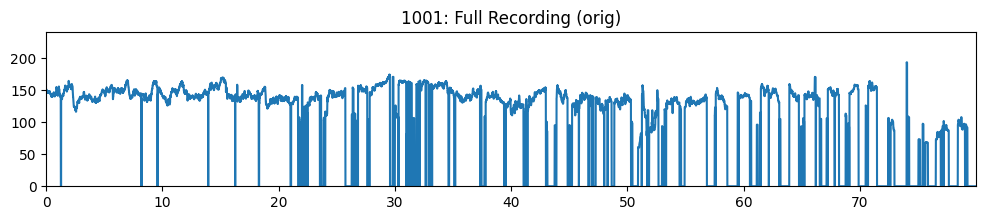

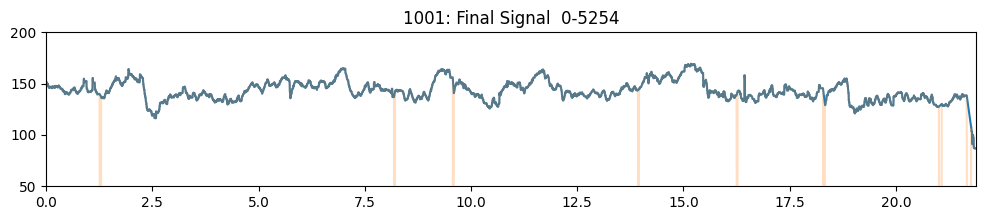

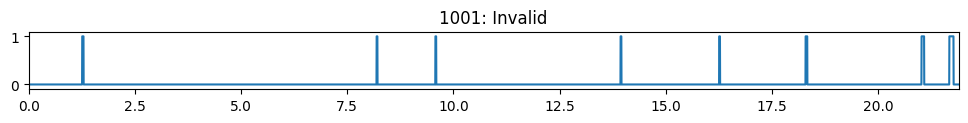

Valid: 98.5%

Record: 1002
nSamples: 19200
['----- Additional parameters for record 1002',
 '-- Outcome measures',
 'pH           7',
 'BDecf        7.92',
 'pCO2         12',
 'BE           -12',
 'Apgar1       8',
 'Apgar5       8',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  41',
 'Weight(g)    2900',
 'Sex          2',
 '-- Maternal (risk-)factors',
 'Age          23',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     0',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 0',
 'Pyrexia      0',
 'Meconium     1',
 '-- Delivery descriptors',
 'Presentation 1',
 'Induced      0',
 'I.stage      220',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     20',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         975666',
 'Rec. type    1',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


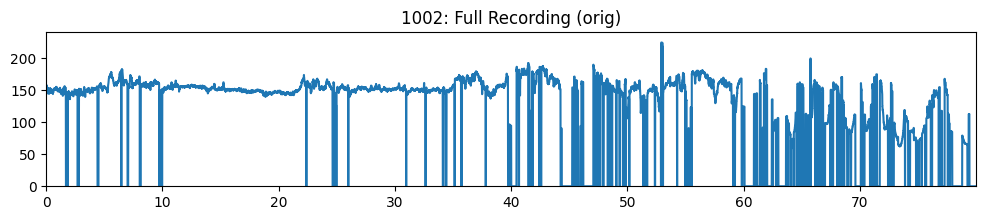

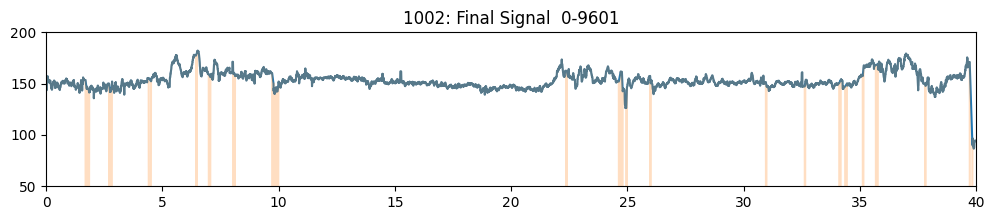

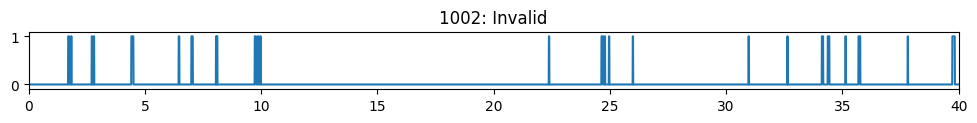

Valid: 97.5%


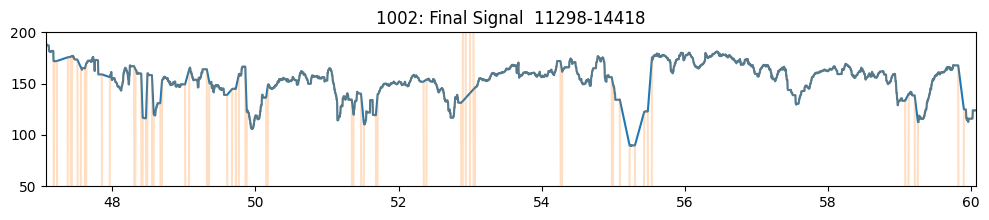

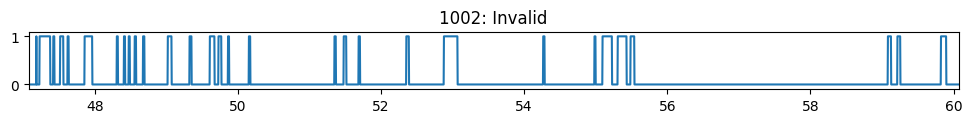

Valid: 88.6%

Record: 1003
nSamples: 18000
['----- Additional parameters for record 1003',
 '-- Outcome measures',
 'pH           7.2',
 'BDecf        3.03',
 'pCO2         8.3',
 'BE           -5.6',
 'Apgar1       7',
 'Apgar5       9',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  40',
 'Weight(g)    3770',
 'Sex          1',
 '-- Maternal (risk-)factors',
 'Age          31',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     0',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 1',
 'Pyrexia      0',
 'Meconium     0',
 '-- Delivery descriptors',
 'Presentation 1',
 'Induced      1',
 'I.stage      215',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     15',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         982315',
 'Rec. type    1',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


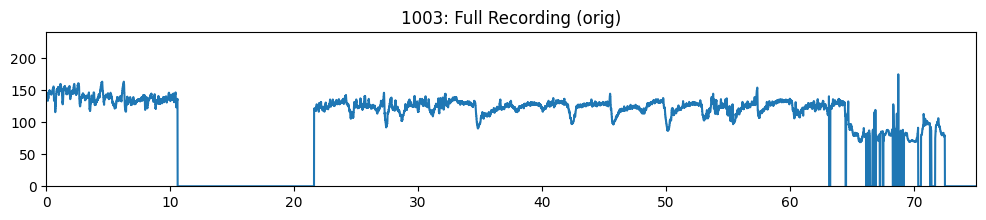

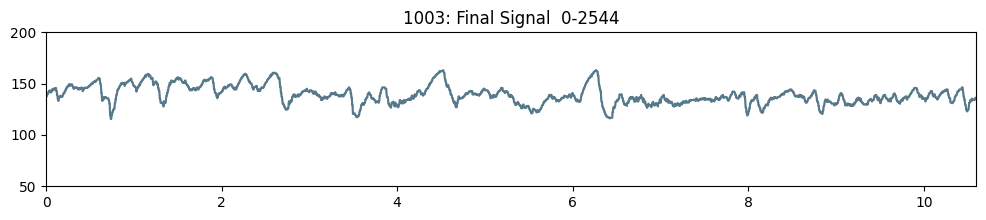

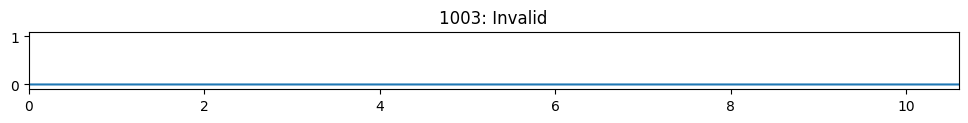

Valid: 100.0%


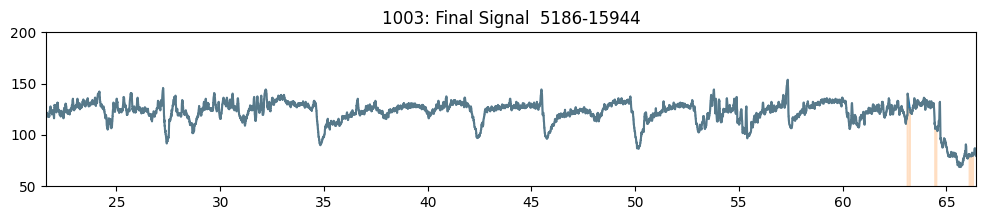

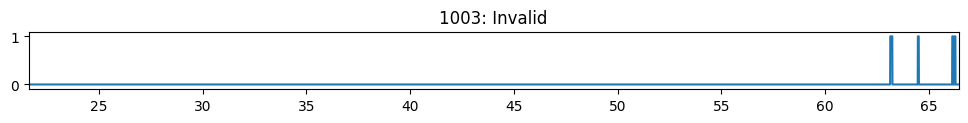

Valid: 99.5%

Record: 1004
nSamples: 16800
['----- Additional parameters for record 1004',
 '-- Outcome measures',
 'pH           7.3',
 'BDecf        5.19',
 'pCO2         5.5',
 'BE           -6.4',
 'Apgar1       8',
 'Apgar5       9',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  41',
 'Weight(g)    3370',
 'Sex          1',
 '-- Maternal (risk-)factors',
 'Age          36',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     0',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 0',
 'Pyrexia      0',
 'Meconium     1',
 '-- Delivery descriptors',
 'Presentation 1',
 'Induced      1',
 'I.stage      55',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     10',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         983277',
 'Rec. type    12',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


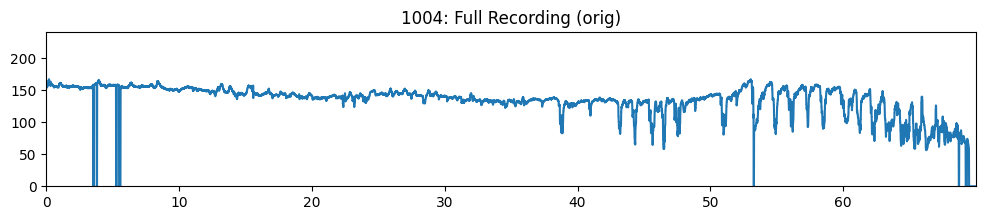

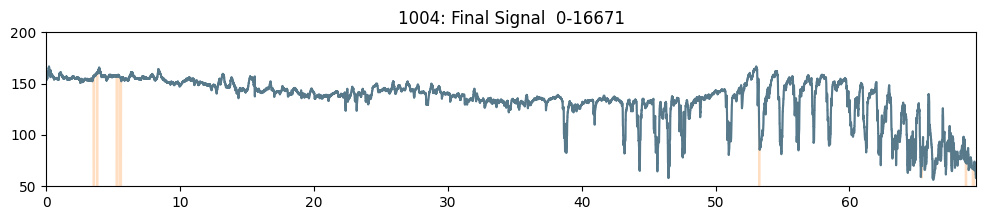

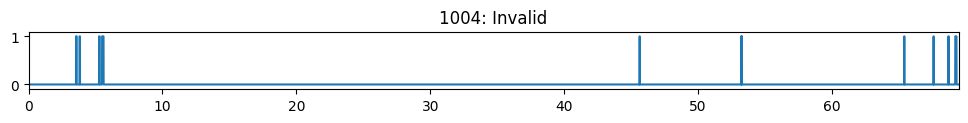

Valid: 99.4%

Record: 1005
nSamples: 18000
['----- Additional parameters for record 1005',
 '-- Outcome measures',
 'pH           7.3',
 'BDecf        4.52',
 'pCO2         5.7',
 'BE           -5.8',
 'Apgar1       9',
 'Apgar5       10',
 '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
 'NICU days    0',
 'Seizures     0',
 'HIE          0',
 'Intubation   0',
 'Main diag.   0',
 'Other diag.  0',
 '-- Fetus/Neonate descriptors',
 'Gest. weeks  41',
 'Weight(g)    3550',
 'Sex          2',
 '-- Maternal (risk-)factors',
 'Age          28',
 'Gravidity    1',
 'Parity       0',
 'Diabetes     0',
 'Hypertension 0',
 'Preeclampsia 0',
 'Liq. praecox 0',
 'Pyrexia      0',
 'Meconium     0',
 '-- Delivery descriptors',
 'Presentation 1',
 'Induced      1',
 'I.stage      114',
 'NoProgress   0',
 'CK/KP        0',
 'II.stage     15',
 'Deliv. type  1',
 '-- Signal information',
 'dbID         983398',
 'Rec. type    1',
 'Pos. II.st.  14400',
 'Sig2Birth    0']


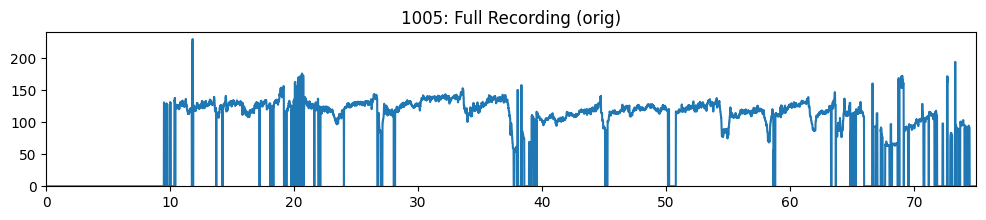

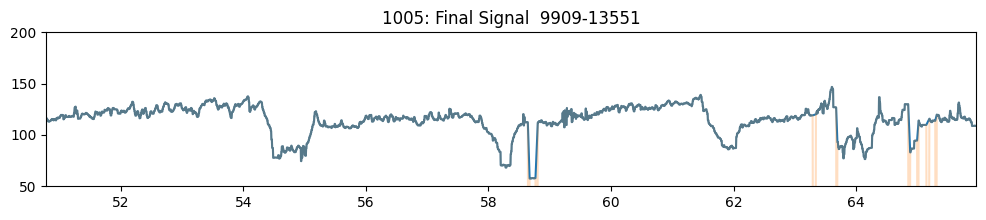

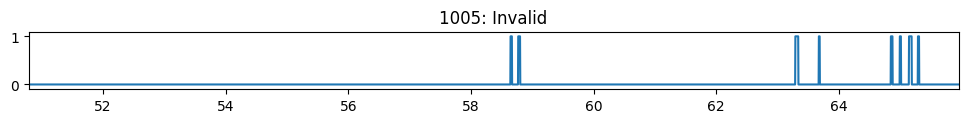

Valid: 98.4%


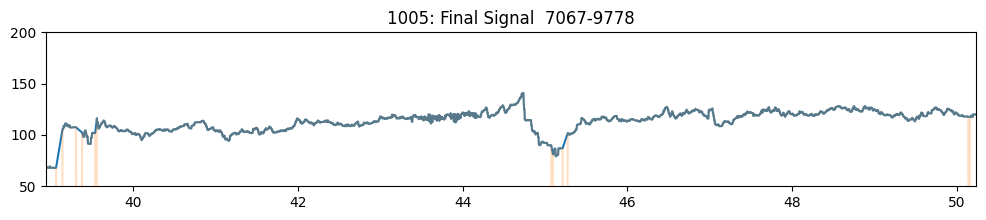

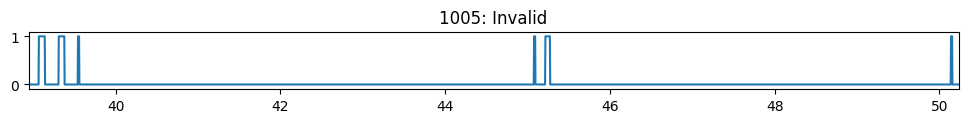

Valid: 97.7%


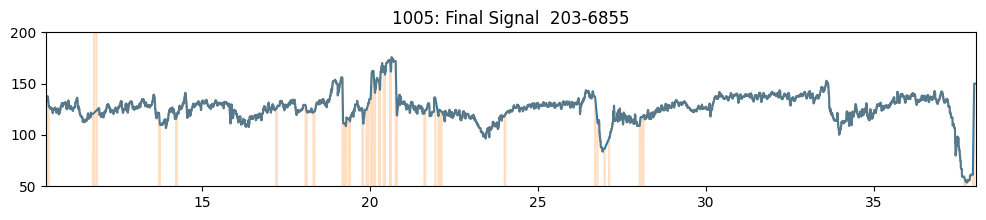

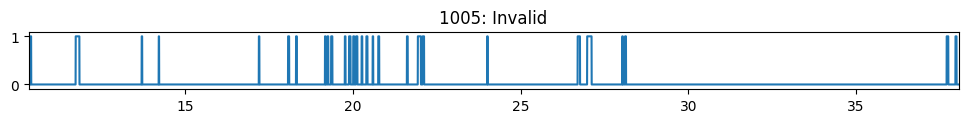

Valid: 96.1%


In [ ]:
nRecordings = 5
for recno in sorted(get_all_recno(RECORDINGS_DIR))[:nRecordings]:
    recno_full = os.path.join(RECORDINGS_DIR, recno)
    print('\nRecord: {}'.format(recno))
    all_sig, meta = wfdb.io.rdsamp(recno_full)
    print('nSamples: {}'.format(all_sig.shape[0]))
    pprint(meta['comments'])

    orig_hr = all_sig[:, 0]
    sig_hr = np.copy(orig_hr)
    sig_uc = all_sig[:, 1]
    ts = np.arange(len(sig_hr))/4.0

    selected_segments = get_valid_segments(orig_hr, ts, recno, verbose=True,
                                           #max_change=15, verbose_details=True
                                          )